In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
from datetime import datetime, timedelta, timezone
import datetime as dt
import scipy.stats as si

import json
import requests
import pandas as pd
from tqdm import tqdm
import sqlite3
import time
import os
import re

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", 30)
pd.options.display.float_format = '{:.4f}'.format

# **1. 連接deribit API語法**

| Method Name                        | Type        | 說明                                    |
|-----------------------|-------------|-----------------------------------------|
| * get_instruments                   | List        |  (history端點)                           |
| get_delivery_prices               | History     | btc_usd每日交割價  (history端點)                    |
| get_last_trades_by_currency  <br> get_last_trades_by_currency_and_time    | History | 所有交易紀錄(history端點)  |
| * get_last_trades_by_instrument <br> * get_last_trades_by_instrument_and_time | History | 所有交易紀錄 (history端點) |
| get_mark_price_history            | History     | 未到期選擇權的標記價格                 |
| get_tradingview_chart_data        | History     | 未到期期貨的OHLCV                 |
| get_historical_volatility         | History     | 過去兩周每小時歷史波動率    |
| get_volatility_index_data         | History     | 2021-03-24以來日、時、分波動率OHLC                    |
| get_last_settlements_by_currency <br> get_last_settlements_by_instrument | Current  |   最近一日交割的所有資料    |
| get_trade_volumes                 | Current     | BTC、ETH、SOL、ETHW過去24h、7D、30D的成交量(spot、call、put、futures)       |
| ticker                            | Current     | 某標的的目前市場數據 best bid ask, greeks, vol...  |
| get_book_summary_by_currency <br> get_book_summary_by_instrument    | Current     | 現在的未平倉合約、24 小時交易量  |
| get_order_book <br> get_order_book_by_instrument_id       | Current    | 現在的訂單簿 bid, ask...       |
| get_index_price                   | Current         | 現在的指數價格       |


In [2]:
def get_deribit(type="", params={""}, network="history"):
    # network = www, history, test
    url = "https://" + network + ".deribit.com/api/v2/public/" + type
    response = requests.get(url, params=params)

    if response.status_code == 200:
        result = json.loads(response.text)
        return result
    else:
        #print("Error, response code:", response.status_code)
        #print(params)
        #time.sleep(5)
        return response.text

In [3]:
instruments = pd.read_csv(f"deribit_data/instruments.csv")

year_list = instruments.query("type=='year'")
quarter_list = instruments.query("type=='quarter'")
week_list = instruments.query("type=='week'")
day_list = instruments.query("type=='day'")

bnspot = pd.read_csv("binance_data/BTCUSDT_spot.csv")

print("year:", len(year_list))
print("quarter:", len(quarter_list))
print("week:", len(week_list))
print("day:", len(day_list))

year: 20
quarter: 28
week: 84
day: 797


In [4]:
print("year:", year_list["date"].to_list())
print("quarter:", quarter_list["date"].to_list())
print("week:", week_list["date"].to_list())
print("day:", day_list["date"].to_list())

year: ['2020/3/27', '2020/6/26', '2020/9/25', '2020/12/25', '2021/3/26', '2021/6/25', '2021/9/24', '2021/12/31', '2022/3/25', '2022/6/24', '2022/9/30', '2022/12/30', '2023/3/31', '2023/6/30', '2023/9/29', '2023/12/29', '2024/3/29', '2024/6/28', '2024/9/27', '2024/12/27']
quarter: ['2021/1/29', '2021/2/26', '2021/4/30', '2021/5/28', '2021/7/30', '2021/8/27', '2021/10/29', '2021/11/26', '2022/1/28', '2022/2/25', '2022/4/29', '2022/5/27', '2022/7/29', '2022/8/26', '2022/10/28', '2022/11/25', '2023/1/27', '2023/2/24', '2023/4/28', '2023/5/26', '2023/7/28', '2023/8/25', '2023/10/27', '2023/11/24', '2024/1/26', '2024/2/23', '2024/4/26', '2024/5/31']
week: ['2021/1/15', '2021/1/22', '2021/2/12', '2021/2/19', '2021/3/12', '2021/3/19', '2021/4/16', '2021/4/23', '2021/5/14', '2021/5/21', '2021/6/11', '2021/6/18', '2021/7/16', '2021/7/23', '2021/8/13', '2021/8/20', '2021/9/10', '2021/9/17', '2021/10/15', '2021/10/22', '2021/11/12', '2021/11/19', '2021/12/10', '2021/12/17', '2021/12/24', '2022/1/1

## **A. History**

### **get_instruments**
* 所有已到期BTC選擇權代號
* 所有未到期BTC選擇權代號

In [5]:
# get_instruments 已到期
type = "get_instruments"
params = {
    "currency":"BTC",
    "kind" : "option",
    "expired": "true",
}
result = get_deribit(type=type, params=params, network="history")

df_expired = pd.DataFrame(result["result"])
df_expired = df_expired[["instrument_name","option_type","strike","creation_timestamp","expiration_timestamp","settlement_period"]]

#df_expired.to_csv("deribit_data/expired_instruments.csv",index=False)
print(df_expired.shape)
df_expired.head(2)

(82220, 6)


,instrument_name,option_type,strike,creation_timestamp,expiration_timestamp,settlement_period
0,BTC-15JUL16-600-C,call,600.0000,1468453919000,1468594800000,week
1,BTC-15JUL16-600-P,put,600.0000,1468453919000,1468594800000,week


In [6]:
# get_instruments 未到期
type = "get_instruments"
params = {
    "currency":"BTC",
    "kind" : "option",
    "expired": "false",
}
result = get_deribit(type=type, params=params, network="www")

df_live = pd.DataFrame(result["result"])
df_live = df_live[["instrument_name","option_type","strike","creation_timestamp","expiration_timestamp","settlement_period"]]

#df_live.to_csv("deribit_data/live_instruments.csv",index=False)
print(df_live.shape)
df_live.head(2)

(832, 6)


,instrument_name,option_type,strike,creation_timestamp,expiration_timestamp,settlement_period
0,BTC-19SEP24-51000-C,call,51000.0000,1726497300000,1726732800000,day
1,BTC-19SEP24-51000-P,put,51000.0000,1726497300000,1726732800000,day


In [ ]:
df_expired = pd.read_csv("deribit_data/expired_instruments.csv")
df_expired.head(2)

### get_last_trades_by_currency_and_time

In [7]:
# get_last_trades_by_currency_and_time
type = "get_last_trades_by_currency_and_time"
start_str = "2021-01-01"
end_str = "2024-01-01"

start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").timestamp() * 1000)

params = {
    "currency":"BTC",
    "start_timestamp": start_timestamp,
    "end_timestamp": end_timestamp,
    "count": 1000,                       # max
    "sorting": "asc",
}
result = get_deribit(type=type, params=params)
df = pd.DataFrame(result["result"]["trades"])
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='ms')  # 'ms'代表毫秒
df

,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,instrument_name,index_price,direction,amount,iv,block_trade_id
0,74687837,112068588,2020-12-31 16:00:00.286,0,28799.5000,28798.1100,BTC-PERPETUAL,28813.5900,sell,10.0000,NaN,NaN
1,74687838,112068589,2020-12-31 16:00:00.304,2,28797.0000,28798.1100,BTC-PERPETUAL,28813.5900,sell,4880.0000,NaN,NaN
2,74687839,112068590,2020-12-31 16:00:00.320,2,28795.5000,28798.1100,BTC-PERPETUAL,28813.5900,sell,900.0000,NaN,NaN
3,74687840,112068591,2020-12-31 16:00:00.348,2,28795.0000,28798.1100,BTC-PERPETUAL,28813.5900,sell,900.0000,NaN,NaN
4,74687841,112068592,2020-12-31 16:00:00.348,2,28794.5000,28798.1100,BTC-PERPETUAL,28813.5900,sell,5100.0000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2183,112069583,2020-12-31 16:08:47.333,3,0.1500,0.1494,BTC-26MAR21-32000-C,28733.1300,buy,0.1000,94.3900,NaN
996,74688611,112069584,2020-12-31 16:08:49.549,0,28730.5000,28734.7000,BTC-PERPETUAL,28739.5400,sell,30.0000,NaN,NaN
997,1522514,112069585,2020-12-31 16:08:50.004,0,29663.0000,29665.2800,BTC-26MAR21,28739.5400,sell,810.0000,NaN,NaN
998,1522515,112069586,2020-12-31 16:08:50.004,2,29662.5000,29665.2800,BTC-26MAR21,28739.5400,sell,220.0000,NaN,NaN


### **get_last_trades_by_instrument_and_time**

In [8]:
# test = df_expired.drop(["tick_size_steps"],axis=1) # df_expired.query("expiration_timestamp > 1700000000000")
test = df_expired
test["creation_timestamp"] = pd.to_datetime(test["creation_timestamp"] , unit="ms")
test["expiration_timestamp"] = pd.to_datetime(test["expiration_timestamp"] , unit="ms")
test["ttm"] = (test["expiration_timestamp"] - test["creation_timestamp"]).dt.days
DEC23 = test.query("expiration_timestamp > '2023-12-29' & ttm > 180 ")["instrument_name"].tolist()
print(len(DEC23))

264


In [9]:
# get_last_trades_by_instrument_and_time
type = "get_last_trades_by_instrument_and_time"
instrument_name = DEC23[60]
start_str = "2020-01-01"
end_str = "2024-01-01"

start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").timestamp() * 1000)

params = {
    "instrument_name": instrument_name,
    "start_timestamp": start_timestamp,
    "end_timestamp": end_timestamp,
    "count": 1000,                       # max
    "sorting": "desc",  # asc, desc, default
}
result = get_deribit(type=type, params=params)

In [10]:
df = pd.DataFrame(result["result"]["trades"])
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='ms')  # 'ms'代表毫秒
df

,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,contracts,amount,combo_id,block_trade_id,combo_trade_id
0,3498,277007450,2023-12-28 17:20:51.872,2,0.0860,0.0857,115.1400,BTC-29DEC23-39000-C,42572.0600,sell,0.1000,0.1000,NaN,NaN,NaN
1,3497,276944580,2023-12-28 07:16:43.314,0,0.0960,0.0959,101.4600,BTC-29DEC23-39000-C,43018.6700,buy,0.9000,0.9000,NaN,NaN,NaN
2,3496,276944344,2023-12-28 07:15:46.376,0,0.0950,0.0950,97.9900,BTC-29DEC23-39000-C,42976.2900,sell,2.0000,2.0000,NaN,NaN,NaN
3,3495,276852473,2023-12-27 17:16:41.613,3,0.0940,0.0941,74.0700,BTC-29DEC23-39000-C,42922.2500,sell,0.8000,0.8000,NaN,NaN,NaN
4,3494,276838392,2023-12-27 15:06:05.353,2,0.0940,0.0938,79.9800,BTC-29DEC23-39000-C,42916.6500,sell,1.0000,1.0000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2503,272421739,2023-11-22 21:48:40.118,2,0.0575,0.0578,54.7300,BTC-29DEC23-39000-C,37652.0200,buy,NaN,1.0000,NaN,NaN,NaN
996,2502,272419655,2023-11-22 21:37:47.568,1,0.0595,0.0595,55.0900,BTC-29DEC23-39000-C,37770.6500,sell,NaN,1.0000,NaN,NaN,NaN
997,2501,272419143,2023-11-22 21:35:23.755,1,0.0595,0.0595,55.1500,BTC-29DEC23-39000-C,37777.9500,sell,NaN,1.0000,NaN,NaN,NaN
998,2500,272418876,2023-11-22 21:34:21.710,1,0.0595,0.0592,55.3200,BTC-29DEC23-39000-C,37766.6200,sell,NaN,1.0000,NaN,NaN,NaN


In [11]:
# 創建date list
start_date = datetime(2023, 12, 28)
end_date = start_date - timedelta(days=180)  # 往前一年的日期
date_list = []
while start_date > end_date:
    date_list.append(start_date.strftime('%Y-%m-%d'))
    start_date -= timedelta(days=7)  # 每次减去7天
date_list.reverse()

In [15]:
# 創建date list
start_date = datetime(2023, 12, 23)
end_date = start_date - timedelta(days=180)  # 往前一年的日期
date_list = []
while start_date > end_date:
    date_list.append(start_date.strftime('%Y-%m-%d'))
    start_date -= timedelta(days=7)  # 每次减去7天
date_list.reverse()


df_weekly_trades = pd.DataFrame()
for instrument in DEC23:
    for date in date_list:
        start_str = "2020-01-01"
        end_str = date

        start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
        end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").timestamp() * 1000)

        params = {
            "instrument_name": instrument,
            "start_timestamp": start_timestamp,
            "end_timestamp": end_timestamp,
            "count": 10,                       # max
            "sorting": "desc",  # asc, desc, default
        }
        result = get_deribit(type=type, params=params)
        try:
            df_weekly_trades = df_weekly_trades.append([result["result"]["trades"][0]])
        except:
            print(date)
            time.sleep(0.1)

2023-07-01
2023-07-08
2023-07-15
2023-07-22
2023-07-29
2023-08-05
2023-08-12
2023-08-19
2023-08-26
2023-09-02
2023-09-09
2023-09-16
2023-09-23
2023-09-30
2023-10-07
2023-10-14
2023-10-21
2023-10-28
2023-11-04
2023-11-11
2023-11-18
2023-11-25
2023-12-02
2023-12-09
2023-12-16
2023-12-23
2023-07-01
2023-07-08
2023-07-15
2023-07-22
2023-07-29
2023-08-05
2023-08-12
2023-08-19
2023-08-26
2023-09-02
2023-09-09
2023-09-16
2023-09-23
2023-09-30
2023-10-07
2023-10-14
2023-10-21
2023-10-28
2023-11-04
2023-11-11
2023-11-18
2023-11-25
2023-12-02
2023-12-09
2023-12-16
2023-12-23
2023-07-01
2023-07-08
2023-07-15
2023-07-22
2023-07-29
2023-08-05
2023-08-12
2023-08-19
2023-08-26
2023-09-02
2023-09-09
2023-09-16
2023-09-23
2023-09-30
2023-10-07
2023-10-14
2023-10-21
2023-10-28
2023-11-04
2023-11-11
2023-11-18
2023-11-25
2023-12-02
2023-12-09
2023-12-16
2023-12-23
2023-07-01
2023-07-08
2023-07-15
2023-07-22
2023-07-29
2023-08-05
2023-08-12
2023-08-19
2023-08-26
2023-09-02
2023-09-09
2023-09-16
2023-09-23

In [16]:
df_weekly_trades#["timestamp"] = pd.to_datetime(df_weekly_trades["timestamp"], unit="ms", utc=False)
#df_weekly_trades.to_csv("deribit_data/BTC-29DEC23_weekly_trades_from06JUL23.csv", index=False)

""


In [ ]:
df_weekly_trades = pd.read_csv("deribit_data/BTC-29DEC23_weekly_trades_from06JUL23.csv")
df_weekly_trades["timestamp"] = pd.to_datetime(df_weekly_trades["timestamp"], unit="ms", utc=False)
df_weekly_trades["timestamp"] = df_weekly_trades["timestamp"].dt.date
df_weekly_trades

In [ ]:
# 找future close
type = "get_last_trades_by_instrument_and_time"
instrument_name = "BTC-29DEC23"
start_str = "2023-10-05"
end_str = "2023-10-06"

start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").timestamp() * 1000)

params = {
    "instrument_name": instrument_name,
    "start_timestamp": start_timestamp,
    "end_timestamp": end_timestamp,
    "count": 1000,                       # max
    "sorting": "desc",  # asc, desc, default
}
result = get_deribit(type=type, params=params)
df = pd.DataFrame(result["result"]["trades"])
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='ms')  # 'ms'代表毫秒
df

## **B. Current**

### **ticker: get 24hr volume**

In [ ]:
result_list = []
for instrument in df_live["instrument_name"].tolist():
    params = {
    "instrument_name":instrument
    }
    result = get_deribit(type=type, params=params, network="www")
    result_list.append(result)

In [ ]:
len(volume_list)

In [ ]:
volume_list = []
for i in result_list:
    try:
        volume_list.append(i["result"]["stats"])
    except:
        volume_list.append({'volume_usd': 0.0,
            'volume': 0.0,
            'price_change': None,
            'low': None,
            'high': None})

In [ ]:
mix = pd.concat([df_live[["instrument_name","option_type","strike","expiration_timestamp","creation_timestamp","price_index"]],
            pd.DataFrame(volume_list)["volume_usd"]],axis=1)
mix["expiration_timestamp"] = pd.to_datetime(mix["expiration_timestamp"], unit="ms", utc=False).dt.strftime("%m-%d")         

#　極端值取代
#mix.at[496,"volume_usd"] = 2000000
#mix.at[440,"volume_usd"] = 2000000

mix.sort_values("volume_usd",ascending=False)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

call = mix.query("option_type=='call'")
put = mix.query("option_type=='put'")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

min_value = min(call["volume_usd"].min(), put["volume_usd"].min())
max_value = max(call["volume_usd"].max(), put["volume_usd"].max())

pivot_table_call = call.pivot_table(values="volume_usd", index="strike", columns="expiration_timestamp")
sns.heatmap(pivot_table_call, cmap="YlGnBu", ax=axes[0], vmin=min_value, vmax=max_value)
axes[0].set_xlabel("Expiration Timestamp")
axes[0].set_ylabel("Strike")
axes[0].set_title("Call Options 24 hr volume")
axes[0].tick_params(axis='x', rotation=30)

pivot_table_put = put.pivot_table(values="volume_usd", index="strike", columns="expiration_timestamp")
sns.heatmap(pivot_table_put, cmap="YlGnBu", ax=axes[1], vmin=min_value, vmax=max_value)
axes[1].set_xlabel("Expiration 24 hr volume")
axes[1].set_ylabel("Strike")
axes[1].set_title("Put Options Heatmap")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()

plt.show()


### **get_mark_price_history**

In [ ]:
# get_instruments 已到期
type = "get_mark_price_history"
params = {
    "instrument_name":"BTC-5APR24",
    "start_timestamp":1554373800000,
    "end_timestamp":1754373800000,
    "resolution":"30",
}
result = get_deribit(type=type, params=params, network="www")

#df = pd.DataFrame(result["result"])
#df_expired = df_expired[["instrument_name","option_type","strike","creation_timestamp","expiration_timestamp","settlement_period"]]

#df_expired.to_csv("deribit_data/expired_instruments.csv")
#df.head(2)
result

### **get_index_price**

In [ ]:
# get_instruments 已到期
type = "get_historical_volatility"
params = {
    "currency":"BTC",
}
result = get_deribit(type=type, params=params, network="www")
df = pd.DataFrame(result["result"])
df[0] = pd.to_datetime(df[0], unit="ms")
df.head()

### get_last_settlements_by_instrument

In [ ]:
# get_last_settlements_by_currency
type = "get_last_settlements_by_currency"
params = {
    "currency":"BTC",
    
}
result = get_deribit(type=type, params=params, network="www")
df = pd.DataFrame(result["result"]["settlements"])
df["timestamp"] = pd.to_datetime(df["timestamp"] , unit="ms")
df

In [ ]:
# get_last_settlements_by_instrument
type = "get_last_settlements_by_instrument"
params = {
    "instrument_name":"BTC-22FEB23",
    "type" : "delivery",
    "count" : 1
}
result = get_deribit(type=type, params=params, network="www")
#df = pd.DataFrame(result["result"])
#df["timestamp"] = pd.to_datetime(df["timestamp"] , unit="ms")
result

### **get_volatility_index_data**
data: 每個數組有 5 個值。對應於時間戳記、波動率指數的開盤價、最高價、最低價和收盤價

最早從2021-3-24開始

In [ ]:
# get_last_settlements_by_instrument
type = "get_volatility_index_data"
params = {
    "currency":"BTC",
    "start_timestamp" : 1616457600000, # 2021-03-24
    "end_timestamp" : 1702900000000,   # 2023-12-18
    "resolution" : "1D"  # 1, 60(1m), 3600(1hr), 43200(12hr), 1D
}
result = get_deribit(type=type, params=params, network="www")
df = pd.DataFrame(result["result"]["data"])
df.columns = ["time","open","high","low","close"]
df["time"] = pd.to_datetime(df["time"] , unit="ms")
df

### **get_trade_volumes**
BTC、ETH、SOL、ETHW過去24h、7D、30D的成交量(spot、call、put、futures)

In [ ]:
# get_trade_volumes
type = "get_trade_volumes"
params = {
    "extended":"true",
}
result = get_deribit(type=type, params=params, network="www")
df = pd.DataFrame(result["result"])
#df.columns = ["time","open","high","low","close"]
#df["time"] = pd.to_datetime(df["time"] , unit="ms")
df

# **2. 下載BTC交易紀錄**

**2-1 下載所有 BTC option 交易紀錄**

In [ ]:
# 連接API下載
# for: get_last_trades_by_currency_and_time
type = "get_last_trades_by_currency_and_time"
start_str = "2024-03-18"  # 2020-01-01 ~ 2024-01-01
end_str = "2024-12-31"

start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp() * 1000)
end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp() * 1000)

df_trades = pd.DataFrame()
count = 0
while start_timestamp < end_timestamp:
    count += 1
    params = {
        "currency":"BTC",
        "kind" : "option",
        "start_timestamp": start_timestamp,
        "end_timestamp": end_timestamp,
        "count": 1000,                       # max
        "sorting": "asc",
    } 
    result = get_deribit(type=type, params=params)
    try:
        df = pd.DataFrame(result["result"]["trades"])
        df_trades = pd.concat([df_trades, df],axis=0)
    except:
        print(start_timestamp, end_timestamp)
        break

    if start_timestamp == df["timestamp"].iloc[-1]:
        break
    else:
        start_timestamp = df["timestamp"].iloc[-1]
        #print(start_timestamp, end_timestamp)

    if count == 500:
        filt_name = "deribit_data/BTC_option_2024_"+str(df["timestamp"].iloc[-1])+".csv"
        #df_trades.to_csv(filt_name, index=False)
        print(pd.to_datetime(start_timestamp, unit="ms", utc=True).strftime("%Y-%m-%d %H:%M:%S"))
        print("save:", filt_name)
        count = 0

filt_name = "deribit_data/BTC_option_2024.csv"
#df_trades.drop_duplicates().to_csv(filt_name, index=False)
print("save:", filt_name)

**2-2 下載特定 BTC futures 交易紀錄**

In [ ]:
# 連接API下載
# for: get_last_trades_by_instrument_and_time
type = "get_last_trades_by_instrument_and_time"
start_str = "2022-12-29"  # 2023-05-28 ~ 2023-12-29
end_str = "2023-12-31"

start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").timestamp() * 1000)
df_trades = pd.DataFrame()
count = 0
while start_timestamp < end_timestamp:
    count += 1
    params = {
        "instrument_name":"BTC-22DEC23",
        "start_timestamp": start_timestamp,
        "end_timestamp": end_timestamp,
        "count": 1000,                       # max
        "sorting": "asc",
    }
    result = get_deribit(type=type, params=params)
    try:
        df = pd.DataFrame(result["result"]["trades"])
        df_trades = pd.concat([df_trades, df],axis=0)
    except:
        print(start_timestamp, end_timestamp)
        break

    if start_timestamp == df["timestamp"].iloc[-1]:
        break
    else:
        start_timestamp = df["timestamp"].iloc[-1]
        #print(start_timestamp, end_timestamp)

    if count == 100:
        filt_name = "deribit_data/future_BTC-29DEC23_"+start_str+"-"+str(df["timestamp"].iloc[-1])+".csv"
        #df_trades.to_csv(filt_name, index=False)
        print("save:", filt_name)
        print(pd.to_datetime(start_timestamp, unit="ms", utc=True).strftime("%Y-%m-%d %H:%M:%S"))
        count = 0

filt_name = "deribit_data/futures_BTC-29DEC23.csv"
df_trades = df_trades.drop_duplicates()
#df_trades.to_csv(filt_name, index=False)
print("save:", filt_name)

In [ ]:
# 連接API下載
# for: get_last_trades_by_currency_and_time
type = "get_last_trades_by_currency_and_time"
start_str = "2020-01-01"  # 2023-05-28 ~ 2023-12-29
end_str = "2024-01-01"

start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp() * 1000)
end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").replace(tzinfo=timezone.utc).timestamp() * 1000)

df_trades = pd.DataFrame()
count = 0
while start_timestamp < end_timestamp:
    count += 1
    params = {
        "currency":"BTC",
        "kind" : "future",
        "start_timestamp": start_timestamp,
        "end_timestamp": end_timestamp,
        "count": 1000,                       # max
        "sorting": "asc",
    }
    result = get_deribit(type=type, params=params)
    try:
        df = pd.DataFrame(result["result"]["trades"])
        df_trades = pd.concat([df_trades, df],axis=0)
    except:
        print(start_timestamp, end_timestamp)
        break

    if start_timestamp == df["timestamp"].iloc[-1]:
        break
    else:
        start_timestamp = df["timestamp"].iloc[-1]
        #print(start_timestamp, end_timestamp)

    if count == 500:
        filt_name = "deribit_data/BTC_future_"+str(df["timestamp"].iloc[-1])+".csv"
        #df_trades.to_csv(filt_name, index=False)
        print(pd.to_datetime(start_timestamp, unit="ms", utc=True).strftime("%Y-%m-%d %H:%M:%S"))
        print("save:", filt_name)
        count = 0

filt_name = "deribit_data/BTC_future.csv"
df_trades.drop_duplicates().to_csv(filt_name, index=False)
print("save:", filt_name)

# **2. 成交量**

In [127]:
option_raw_trades = pd.read_csv("deribit_data/BTC-option/BTC_option_all.csv")
option_raw_trades = option_raw_trades.query("date<'2024-05-01'")
print(len(option_raw_trades))
option_raw_trades.head(2)

12613048


,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,amount,date,hour,expiration_date,expiration_month,type,strike,price_usd,volume
0,5,55443031,1577836855204,2,0.0800,0.0871,0.0000,BTC-10JAN20-7750-P,7162.0900,buy,0.7000,2020-01-01,0,10JAN20,2020-01,Put,7750,572.9672,401.0770
1,459,55443288,1577837116822,0,0.0210,0.0210,44.2600,BTC-3JAN20-7250-P,7160.9800,buy,0.2000,2020-01-01,0,3JAN20,2020-01,Put,7250,150.3806,30.0761


In [145]:
option_raw_trades["observe_month"] =  pd.to_datetime(option_raw_trades["date"]).dt.strftime("%Y-%m")
option_raw_trades["days"] = (pd.to_datetime(option_raw_trades["expiration_date"], format='%d%b%y') - pd.to_datetime(option_raw_trades["date"])).dt.days 
option_raw_trades["T"] = option_raw_trades["days"] /365
option_raw_trades["days_category"] = pd.cut(option_raw_trades["days"], bins=[-float("inf"), 14, 30, 90, 180, float("inf")], 
                                            labels=["<=14 days", "15-30", "31-90", "90-180", ">180"], right=False)

option_raw_trades["moneyness"] = option_raw_trades["strike"] / option_raw_trades["index_price"]


call_raw = option_raw_trades.query("type=='Call'")
put_raw = option_raw_trades.query("type=='Put'")

moneyness_labels = [
    '<=0.9', '0.9-1.0', 
    '1.0-1.1', '1.1-1.2', '1.2-1.3', '1.3-1.4', '1.4-1.5', '1.5-1.6', 
    '1.6-1.7', '1.7-1.8', '1.8-1.9', '1.9-2.0', '>2.0'
]
call_raw["moneyness_category"] = pd.cut(call_raw["moneyness"], bins=[-float("inf"), 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 
                                        1.6, 1.7, 1.8, 1.9, 2, float("inf")], labels=moneyness_labels, right=False)

moneyness_labels = [
    '<=0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0', 
    '1.0-1.1', '>1.1'
]
put_raw["moneyness_category"] = pd.cut(put_raw["moneyness"], bins=[-float("inf"), 0.7, 0.8, 0.9, 1, 1.1, float("inf")], labels=moneyness_labels, right=False)


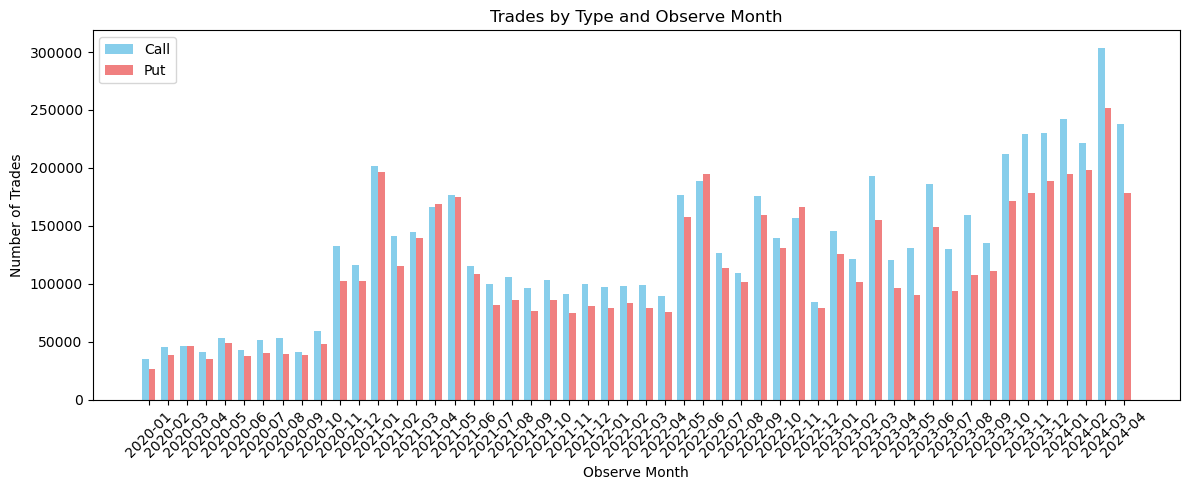

In [114]:
tradescount_bytime = option_raw_trades.groupby(["type", "observe_month"]).count()[["volume"]]
tradescount_bytime.rename(columns={"volume": "trades"}, inplace=True)
tradescount_bytime = tradescount_bytime.reset_index()

fig, ax = plt.subplots(figsize=(12, 5))

bar_width = 0.35
unique_types = tradescount_bytime['type'].unique()
unique_dates = tradescount_bytime['observe_month'].unique()
index = range(len(unique_dates))

colors = {
    'Call': 'skyblue',
    'Put': 'lightcoral'
}

for i, trade_type in enumerate(unique_types):
    type_data = tradescount_bytime[tradescount_bytime['type'] == trade_type]
    bar_positions = [x + i * bar_width for x in index]
    
    ax.bar(bar_positions, type_data.set_index('observe_month')['trades'], bar_width, label=trade_type, color=colors[trade_type])

ax.set_xlabel('Observe Month')
ax.set_ylabel('Number of Trades')
ax.set_title('Trades by Type and Observe Month')
ax.set_xticks([r + bar_width / 2 for r in range(len(unique_dates))])
ax.set_xticklabels(unique_dates)

ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


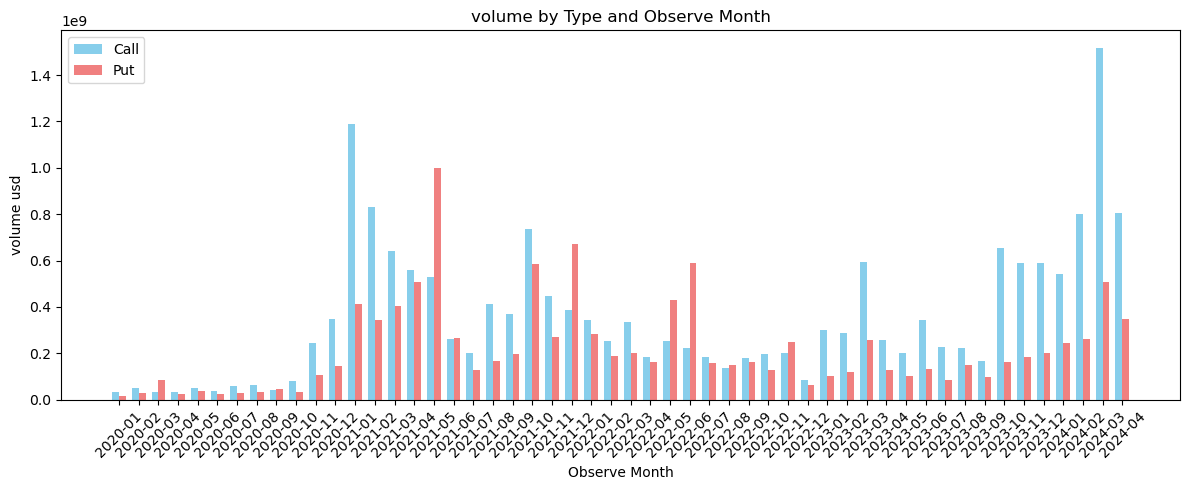

In [116]:
volume_bytime = option_raw_trades.groupby(["type", "observe_month"]).sum()[["volume"]]
volume_bytime = volume_bytime.reset_index()

fig, ax = plt.subplots(figsize=(12, 5))

bar_width = 0.35
unique_types = tradescount_bytime['type'].unique()
unique_dates = tradescount_bytime['observe_month'].unique()
index = range(len(unique_dates))

colors = {
    'Call': 'skyblue',
    'Put': 'lightcoral'
}

for i, trade_type in enumerate(unique_types):
    type_data = volume_bytime[volume_bytime['type'] == trade_type]
    bar_positions = [x + i * bar_width for x in index]
    
    ax.bar(bar_positions, type_data.set_index('observe_month')['volume'], bar_width, label=trade_type, color=colors[trade_type])

ax.set_xlabel('Observe Month')
ax.set_ylabel('volume usd')
ax.set_title('volume by Type and Observe Month')
ax.set_xticks([r + bar_width / 2 for r in range(len(unique_dates))])
ax.set_xticklabels(unique_dates)

ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [126]:
option_raw_trades[["type","moneyness_category"]]

,type,moneyness_category
0,Put,1.0-1.1
1,Put,1.0-1.1
2,Put,1.0-1.1
3,Call,1.0-1.1
4,Call,1.0-1.1
...,...,...
12613043,Put,0.9-1.0
12613044,Put,0.9-1.0
12613045,Put,0.9-1.0
12613046,Put,0.9-1.0


In [146]:
call_volume = call_raw.groupby(["moneyness_category", "days_category"]).sum()[["volume","amount"]].unstack()
put_volume = put_raw.groupby(["moneyness_category", "days_category"]).sum()[["volume","amount"]].unstack()
put_volume

volume                                 \
days_category            <=14 days          15-30           31-90   
moneyness_category                                                  
<=0.7                12107962.4025  27839314.8419  119795419.8908   
0.7-0.8              37216439.1333  84881130.9094  248356613.8664   
0.8-0.9             213693712.4073 347755226.1270  677076510.4266   
0.9-1.0            1676196036.7657 915995323.0268 1066160901.7192   
1.0-1.1             834545814.8474 382791095.2189  589103668.2066   
>1.1                585567132.1285 171417348.4085  479810705.3923   

                                                       amount              \
days_category              90-180           >180    <=14 days       15-30   
moneyness_category                                                          
<=0.7              133280132.6609 157361221.4105  153891.2000 200952.2000   
0.7-0.8            132309669.4081 114794165.9085  353875.4000 282061.2000   
0.8-0.9            233150518.7778 158750717.4589 1145001.1000 646906.7000   
0.9-1.0            268337700.0924 183806721.9026 4607526.3000 838037.5000   
1.0-1.1            193018490.8843 157418347.9734  790513.1000 173049.7000   
>1.1               821145827.0356 389885420.8049   76661.3000  24378.8000   

                                                        
days_category            31-90      90-180        >180  
moneyness_category                                      
<=0.7              357867.6000 183678.7000 118529.7000  
0.7-0.8            368093.1000  83768.5000  41790.9000  
0.8-0.9            583238.4000  95350.4000  37431.2000  
0.9-1.0            535292.3000  75346.5000  33748.9000  
1.0-1.1            169798.8000  40350.3000  20137.9000  
>1.1                46437.1000  25436.1000  25864.3000

In [138]:
put_volume["volume"]/1000000

days_category,short-term,mid-term,long-term
moneyness_category,,,
<=0.7,12.1080,27.8393,410.4368
0.7-0.8,37.2164,84.8811,495.4604
0.8-0.9,213.6937,347.7552,1068.9777
0.9-1.0,1676.1960,915.9953,1518.3053
1.0-1.1,834.5458,382.7911,939.5405
>1.1,585.5671,171.4173,1690.8420


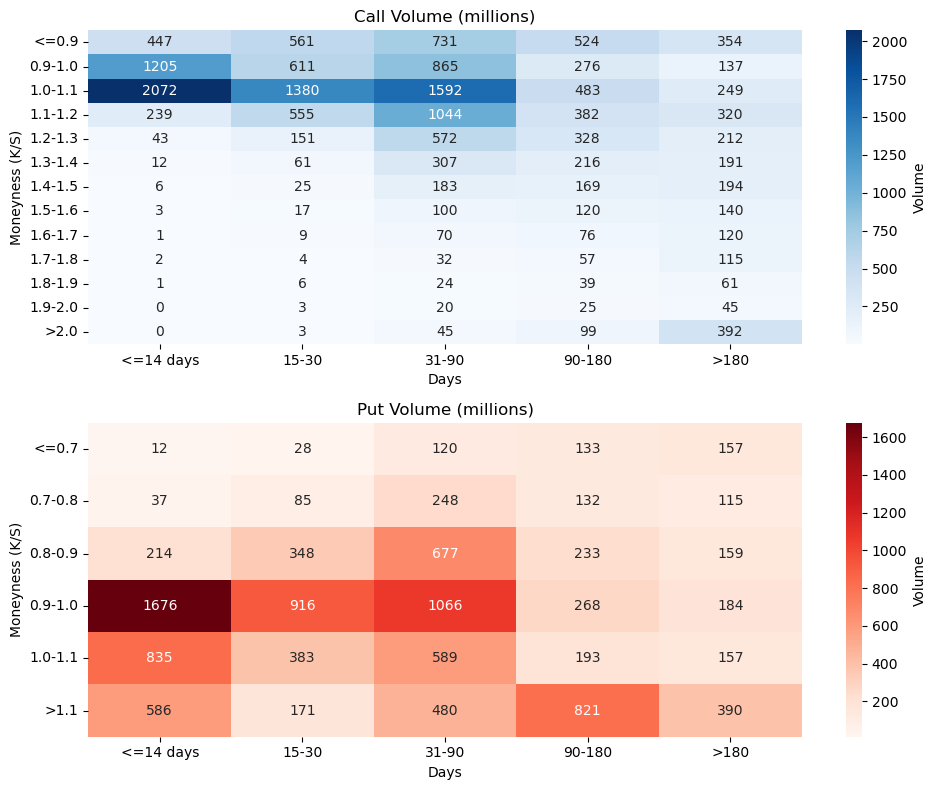

In [148]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# 繪製 Call 的熱力圖
sns.heatmap(call_volume["volume"]/1000000, annot=True, fmt=".0f", cmap="Blues", cbar_kws={'label': 'Volume'}, ax=ax1)
ax1.set_title('Call Volume (millions)')
ax1.set_xlabel('Days')
ax1.set_ylabel('Moneyness (K/S)')

# 繪製 Put 的熱力圖
sns.heatmap(put_volume["volume"]/1000000, annot=True, fmt=".0f", cmap="Reds", cbar_kws={'label': 'Volume'}, ax=ax2)
ax2.set_title('Put Volume (millions)')
ax2.set_xlabel('Days')
ax2.set_ylabel('Moneyness (K/S)')

plt.tight_layout()
plt.show()


# **3. 整理資料**

## **3-1 整理option OHLCV 29DEC23**

**ohlcv**

option_raw_trades

->call_ohlcv

->put_ohlcv

->index_ohlc

In [ ]:
# 讀取並合併所有 option 交易紀錄
option_raw_trades = pd.DataFrame()
for year in ["2020", "2021", "2022", "2023"]:
    df = pd.read_csv("deribit_data/BTC-option/BTC_option_" + year + ".csv")
    option_raw_trades = pd.concat([option_raw_trades, df],axis=0)
#option_raw_trades["timestamp"] = pd.to_datetime(option_raw_trades["timestamp"], unit="ms", utc=True)
option_raw_trades = option_raw_trades.drop_duplicates().reset_index(drop=True).drop(["block_trade_id","liquidation","combo_id","combo_trade_id"],axis=1)

# 添加到期資訊欄位
date_time = pd.to_datetime(option_raw_trades["timestamp"], unit="ms", utc=True)
option_raw_trades["date"] = date_time.dt.date
option_raw_trades["hour"] = date_time.dt.hour
option_raw_trades["expiration_date"] = option_raw_trades["instrument_name"].str.extract(r'-(\d+[A-Z]+\d+)-')
option_raw_trades["expiration_month"] = pd.to_datetime(option_raw_trades["expiration_date"], format='%d%b%y').dt.strftime('%Y-%m')

# 添加type, strike, price_usd
def option_type(letter):
    if letter == "C":   return "Call"
    elif letter == "P": return "Put"
option_raw_trades["type"] = option_raw_trades["instrument_name"].str[-1].apply(option_type)
option_raw_trades["strike"] = option_raw_trades['instrument_name'].str.extract(r'-(\d+)-[CP]$')
option_raw_trades["price_usd"] = option_raw_trades["price"] * option_raw_trades["index_price"]
option_raw_trades["volume"] = option_raw_trades["price_usd"] * option_raw_trades["amount"] 
#option_raw_trades.to_csv("deribit_data/BTC-option/BTC_option_all.csv", index=False)

In [ ]:
option_29DEC23 = option_raw_trades.query("expiration_date == '29DEC23'")
option_29DEC23['date'] = pd.to_datetime(option_29DEC23['date'])
call_df = option_29DEC23[option_29DEC23['type'] == 'Call']
put_df = option_29DEC23[option_29DEC23['type'] == 'Put']

grouped = call_df.groupby([call_df['date'], 'strike'])
call_ohlcv = grouped['price_usd'].agg(['first', 'max', 'min', 'last'])
call_ohlcv.columns = ['Open', 'High', 'Low', 'Close']
call_ohlcv['Volume'] = grouped['volume'].sum()

grouped = put_df.groupby([put_df['date'], 'strike'])
put_ohlcv = grouped['price_usd'].agg(['first', 'max', 'min', 'last'])
put_ohlcv.columns = ['Open', 'High', 'Low', 'Close']
put_ohlcv['Volume'] = grouped['volume'].sum()

grouped = option_29DEC23.groupby([option_29DEC23['date']])
index_ohlc = grouped['index_price'].agg(['first', 'max', 'min', 'last'])
index_ohlc.columns = ['Open', 'High', 'Low', 'Close']
index_ohlc.index = pd.to_datetime(index_ohlc.index)

In [ ]:
call_ohlcv
#put_ohlcv

In [ ]:
# 找特定日期
put_ohlcv.loc["2023-10-08"]

**dailyclose_byStrike**

轉成每日收盤by執行價

call_ohlcv

-> dailyclose_byStrike

In [ ]:
# Call & Put
# 創建 date list
start_date = dt.datetime(2022, 12, 29)
end_date = dt.datetime(2023, 12, 30) 
date_list = []
while start_date < end_date:
    date_list.append(start_date.strftime('%Y-%m-%d'))
    start_date += dt.timedelta(days=1)  # 每次减去1天
date_list = pd.to_datetime(date_list)  # = call_ohlcv.index.get_level_values('date').unique()

# 創建 callprice, idxprice DataFrame 
call_strike = pd.DataFrame(index=date_list, columns=sorted(option_29DEC23["strike"].unique().astype(int)))
put_strike = pd.DataFrame(index=date_list, columns=sorted(option_29DEC23["strike"].unique().astype(int)))

df_idxprice = pd.DataFrame(index=date_list, columns=["index_price"])

for date in call_strike.index:
    df_idxprice.at[date, "index_price"] = index_ohlc["Close"].loc[date]
    for strike in call_strike.columns:
        try:
            Callclose = call_ohlcv.loc[date, str(strike)]["Close"]
            call_strike.at[date, strike] = Callclose
        except:
            call_strike.at[date, strike] = 0
        try:
            Putclose = put_ohlcv.loc[date, str(strike)]["Close"]
            put_strike.at[date, strike] = Putclose
        except:
            put_strike.at[date, strike] = 0

call_strike
#call_strike.to_csv("deribit_data\BTC-option\call_strike_29DEC23.csv")
#put_strike.to_csv("deribit_data/BTC-option/put_strike_29DEC23.csv")
#df_idxprice.to_csv("deribit_data/BTC_index_close.csv")

## **3-2 整理futures OHLCV 29DEC23**

**ohlcv**

futures_raw_trades

->

In [ ]:
# 讀取 futures raw trades
# price: usd
# amount: usd
futures_raw_trades = pd.read_csv("deribit_data/BTC-futures/futures_BTC-29DEC23.csv")

# 添加到期資訊欄位
date_time = pd.to_datetime(futures_raw_trades["timestamp"], unit="ms", utc=True)
futures_raw_trades["date"] = date_time.dt.date
futures_raw_trades["hour"] = date_time.dt.hour
futures_raw_trades["expiration_date"] = futures_raw_trades['instrument_name'].str.split('-').str[1]
futures_raw_trades["expiration_month"] = pd.to_datetime(futures_raw_trades["expiration_date"], format='%d%b%y').dt.strftime('%Y-%m')

In [ ]:
futures_raw_trades['date'] = pd.to_datetime(futures_raw_trades["timestamp"], unit="ms", utc=True)

grouped = futures_raw_trades.groupby([futures_raw_trades['date'].dt.date])
futures_29DEC23_ohlc = grouped['price'].agg(['first', 'max', 'min', 'last'])
futures_29DEC23_ohlc.columns = ['Open', 'High', 'Low', 'Close']
futures_29DEC23_ohlc['Volume'] = grouped['amount'].sum()
futures_29DEC23_ohlc.index = pd.to_datetime(futures_29DEC23_ohlc.index)
futures_29DEC23_ohlc
#futures_29DEC23_ohlc.to_csv("deribit_data/BTC-futures/futures_BTC-29DEC23_ohlcv.csv")

In [ ]:
import mplfinance as mpf 
mpf.plot(futures_29DEC23_ohlc, type='candle', title="OHLCV", ylabel='Price', volume=True)

## **3-3 option 指定到期日 function**

In [ ]:
option_raw_trades = pd.read_csv("deribit_data/BTC-option/BTC_option_all.csv")
option_raw_trades.head(2)

In [ ]:
first_trade = option_raw_trades.query("trade_seq==1")
ddd = first_trade["expiration_date"]
days = pd.to_datetime(ddd, format='%d%b%y') - pd.to_datetime(first_trade["date"])
year_idx = days[days > pd.Timedelta(days=300)].index
q_idx = days[(days > pd.Timedelta(days=80))&(days < pd.Timedelta(days=100))].index

# 季度合約
print(option_raw_trades["expiration_date"].loc[q_idx].unique())

# 年度合約
print(option_raw_trades["expiration_date"].loc[year_idx].unique())

In [ ]:
def get_one_option(expiration_date='29DEC23'):
    # Step 1. 整理 ohlcv
    option_29DEC23 = option_raw_trades.query(f"expiration_date == '{expiration_date}'")
    option_29DEC23['date'] = pd.to_datetime(option_29DEC23['date'])
    call_df = option_29DEC23[option_29DEC23['type'] == 'Call']
    put_df = option_29DEC23[option_29DEC23['type'] == 'Put']

    grouped = call_df.groupby([call_df['date'], 'strike'])
    call_ohlcv = grouped['price_usd'].agg(['first', 'max', 'min', 'last'])
    call_ohlcv.columns = ['Open', 'High', 'Low', 'Close']
    call_ohlcv['Volume'] = grouped['volume'].sum()

    grouped = put_df.groupby([put_df['date'], 'strike'])
    put_ohlcv = grouped['price_usd'].agg(['first', 'max', 'min', 'last'])
    put_ohlcv.columns = ['Open', 'High', 'Low', 'Close']
    put_ohlcv['Volume'] = grouped['volume'].sum()

    grouped = option_29DEC23.groupby([option_29DEC23['date']])
    index_ohlc = grouped['index_price'].agg(['first', 'max', 'min', 'last'])
    index_ohlc.columns = ['Open', 'High', 'Low', 'Close']
    index_ohlc.index = pd.to_datetime(index_ohlc.index)
    
    # Step 2. 整理成 call put 的 date-strike df
    # 創建 date list
    start_date = call_ohlcv.index.get_level_values("date")[0]
    end_date = call_ohlcv.index.get_level_values("date")[-1]
    
    date_list = []
    while start_date < end_date:
        date_list.append(start_date.strftime('%Y-%m-%d'))
        start_date += dt.timedelta(days=1)  # 每次减去1天
    date_list = pd.to_datetime(date_list)  # = call_ohlcv.index.get_level_values('date').unique()

    # 創建 callprice, idxprice DataFrame 
    call_strike = pd.DataFrame(index=date_list, columns=sorted(option_29DEC23["strike"].unique().astype(int)))
    put_strike = pd.DataFrame(index=date_list, columns=sorted(option_29DEC23["strike"].unique().astype(int)))
    df_idxprice = pd.DataFrame(index=date_list, columns=["index_price"])

    for date in call_strike.index:
        try:
            df_idxprice.at[date, "index_price"] = index_ohlc["Close"].loc[date]
        except:
            print(date)
            pass
        for strike in call_strike.columns:
            
            #print("A",call_ohlcv.loc[date, strike]["Close"])
            try:
                Callclose = call_ohlcv.loc[date, strike]["Close"]
                call_strike.at[date, strike] = Callclose
            except:
                call_strike.at[date, strike] = 0
            try:
                Putclose = put_ohlcv.loc[date, strike]["Close"]
                put_strike.at[date, strike] = Putclose
            except:
                put_strike.at[date, strike] = 0

    return call_strike, put_strike, df_idxprice
    #call_strike.to_csv("deribit_data\BTC-option\call_strike_29DEC23.csv")
    #put_strike.to_csv("deribit_data/BTC-option/put_strike_29DEC23.csv")
    #df_idxprice.to_csv("deribit_data/BTC_index_close.csv")

In [ ]:
expiration_date = "25NOV22"
call_strike, put_strike, df_idxprice = get_one_option(expiration_date)
call_strike

In [ ]:
call_strike.to_csv(f"deribit_data/BTC-option/call_strike_{expiration_date}.csv")
put_strike.to_csv(f"deribit_data/BTC-option/put_strike_{expiration_date}.csv")
df_idxprice.to_csv(f"deribit_data/BTC-option/BTC_index_{expiration_date}.csv")
print(f"{expiration_date} save")

In [ ]:
# 已經下載好
folder_path = 'deribit_data/BTC-call'
file_names = os.listdir(folder_path)
file_names = [file_name for file_name in file_names if os.path.isfile(os.path.join(folder_path, file_name))]
expiration_exclude = [re.search(r'call_strike_(\d{4}-\d{2}-\d{2})\.csv', file_name).group(1) for file_name in file_names]
expiration_exclude

# 所有週五的日期
start_date = datetime(2021, 1, 8)
end_date = datetime(2024, 5, 31)

date_list1 = []
while start_date < end_date:
    date_list1.append(start_date.strftime("%Y-%m-%d").upper())
    start_date += timedelta(days=1) 

# 排除已經下載好的
date_list1 = [date for date in date_list1 if date not in expiration_exclude]
date_list2 = [datetime.strptime(date_str, "%Y-%m-%d").strftime("%d%b%y").upper() for date_str in date_list1]

# 尚未下載的周五日期
print(expiration_exclude)
print(len(date_list1))
print(date_list1)
print(date_list2)


In [ ]:
# 迴圈
instrument_list = date_list2
formatted_dates = []  # ['2021-07-30', '2021-08-27',...]
for date_str in instrument_list:
    date_obj = datetime.strptime(date_str, '%d%b%y')
    formatted_date = date_obj.strftime('%Y-%m-%d')
    formatted_dates.append(formatted_date)


for idx in range(len(instrument_list)):#len(instrument_list)
    expiration_date = instrument_list[idx]
    #expiration_date = "30DEC22"
    try:
        call_strike, put_strike, df_idxprice = get_one_option(expiration_date)
        call_strike.to_csv(f"deribit_data/BTC-call/call_strike_{formatted_dates[idx]}.csv")
        put_strike.to_csv(f"deribit_data/BTC-put/put_strike_{formatted_dates[idx]}.csv")
        df_idxprice.to_csv(f"deribit_data/BTC-index/BTC_index_{formatted_dates[idx]}.csv")
        print(f"{expiration_date} save")
    except:
        print(f"{expiration_date} error")

## **3-4 futures 指定到期日 function**

In [ ]:
# v1
def get_one_future(expiration_date="29DEC23"):
    print("v1 daily")
    type = "get_last_trades_by_instrument_and_time"
    start_str = "2020-01-01" 
    end_str = "2024-12-31"

    formatted_date = datetime.strptime(expiration_date, "%Y-%m-%d").strftime("%d%b%y").upper()

    start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
    end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").timestamp() * 1000)

    df_trades = pd.DataFrame()
    count = 0
    while start_timestamp < end_timestamp:
        count += 1
        params = {
            "instrument_name":"BTC-"+formatted_date,
            "start_timestamp": start_timestamp,
            "end_timestamp": end_timestamp,
            "count": 1000,                       # max
            "sorting": "asc",
        }
        result = get_deribit(type=type, params=params)
        try:
            df = pd.DataFrame(result["result"]["trades"])
            df_trades = pd.concat([df_trades, df],axis=0)
        except:
            print(start_timestamp, end_timestamp)
            break

        if start_timestamp == df["timestamp"].iloc[-1]:
            break
        else:
            start_timestamp = df["timestamp"].iloc[-1]
            break
            #print(start_timestamp, end_timestamp)

        if count == 100:
            last_date = pd.to_datetime(df['timestamp'].iloc[-1], unit='ms', utc=True).strftime('%Y-%m-%d')
            filt_name = f"deribit_data/BTC-futures/future_BTC-{expiration_date}_{start_str}-{last_date}.csv"
            #df_trades.to_csv(filt_name, index=False)
            print("save:", filt_name) 
            #print(start_timestamp)
            count = 0
        if count == 10:
            print(pd.to_datetime(start_timestamp, unit="ms", utc=True).strftime("%Y-%m-%d %H:%M:%S"))

    filt_name = f"deribit_data/raw/year/BTC_futures-{expiration_date}.csv"
    df_trades = df_trades.drop_duplicates().reset_index(drop=True).drop(["contracts","combo_id","combo_trade_id"],axis=1)
    df_trades["date"] = pd.to_datetime(df_trades["timestamp"], unit="ms", utc=False).dt.date
    #df_trades.to_csv(filt_name, index=False)
    print("save:", filt_name)
    return df_trades

In [ ]:
# 讀取檔名
def read_file_list(folder_path, start_name):
    #folder_path = 'deribit_data/BTC-index/day'
    file_names = os.listdir(folder_path)
    file_names = [file_name for file_name in file_names if os.path.isfile(os.path.join(folder_path, file_name))]
    pattern = re.compile(rf'{start_name}_(\d{{4}}-\d{{2}}-\d{{2}})\.csv')
    expiration_list = [pattern.search(file_name).group(1) for file_name in file_names if pattern.search(file_name)]
    return expiration_list

year_list = read_file_list("deribit_data/BTC-call/year", "call_strike")
quarter_list = read_file_list("deribit_data/BTC-call/quarter", "call_strike")
week_list = read_file_list("deribit_data/BTC-call/week", "call_strike")
day_list = read_file_list("deribit_data/BTC-call/day", "call_strike")

print("year:", len(year_list))
print("quarter:", len(quarter_list))
print("week:", len(week_list))
print("day:", len(day_list))

In [ ]:
df_trades = get_one_future("2024-05-31")
df_trades

In [ ]:
option_raw_trades

29MAR24
28JUN24
27SEP24
27DEC24
26APR24

In [ ]:
start_str = "2020-01-01" 
start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
print(start_timestamp)

In [ ]:
# v2 download close/hr
def get_one_future(expiration_date='29DEC23'):
    print("v2")
    type = "get_last_trades_by_instrument_and_time"
    start_str = "2020-01-01" 
    end_str = "2024-12-31"

    start_timestamp = int(datetime.strptime(start_str, "%Y-%m-%d").timestamp() * 1000)
    end_timestamp = int(datetime.strptime(end_str, "%Y-%m-%d").timestamp() * 1000)
    df_trades = pd.DataFrame()
    count = 0
    while start_timestamp < end_timestamp:
        count += 1
        params = {
            "instrument_name":"BTC-"+expiration_date,
            "start_timestamp": start_timestamp,
            "end_timestamp": end_timestamp,
            "count": 1000,                       # max
            "sorting": "asc",
        }
        result = get_deribit(type=type, params=params)
        try:
            df = pd.DataFrame(result["result"]["trades"])
            df_trades = pd.concat([df_trades, df],axis=0)
        except:
            print(start_timestamp, end_timestamp)
            break

        if start_timestamp == df["timestamp"].iloc[-1]:
            break
        else:
            start_timestamp = df["timestamp"].iloc[-1]
            #print(start_timestamp, end_timestamp)


    #filt_name = f"deribit_data/futures_BTC-{expiration_date}.csv"
    df_trades = df_trades.drop_duplicates()
    #df_trades.to_csv(filt_name, index=False)
    #print("save:", filt_name)
    return df_trades

In [ ]:
type = "get_last_trades_by_instrument_and_time"
expiration_date = "11NOV22"
start_timestamp = int(datetime.strptime("2020-01-01", "%Y-%m-%d").timestamp() * 1000)
end_timestamp = int(datetime.strptime("2023-10-10", "%Y-%m-%d").timestamp() * 1000)

params = {
            "instrument_name":"BTC-"+expiration_date,
            "start_timestamp": start_timestamp,
            "end_timestamp": end_timestamp,
            "count": 1000,                       # max
            "sorting": "desc",
}
result = get_deribit(type=type, params=params)

df = pd.DataFrame(result["result"]["trades"])
df

In [ ]:
expiration_date='18NOV22'
df_trades = get_one_future(expiration_date=expiration_date)
df_trades

In [ ]:
df_trades.to_csv(f"deribit_data/BTC-futures/raw/futures_BTC-{expiration_date}.csv")

In [ ]:
def get_ohlc(expiration_date='29DEC23'):
    
    # 讀取 futures raw trades
    futures_raw_trades = pd.read_csv(f"deribit_data/BTC-futures/raw/futures_BTC-{expiration_date}.csv")

    # 添加到期資訊欄位
    date_time = pd.to_datetime(futures_raw_trades["timestamp"], unit="ms", utc=True)
    futures_raw_trades["date"] = date_time.dt.date
    futures_raw_trades["hour"] = date_time.dt.hour
    futures_raw_trades["expiration_date"] = futures_raw_trades['instrument_name'].str.split('-').str[1]
    futures_raw_trades["expiration_month"] = pd.to_datetime(futures_raw_trades["expiration_date"], format='%d%b%y').dt.strftime('%Y-%m')
    futures_raw_trades['date'] = pd.to_datetime(futures_raw_trades["timestamp"], unit="ms", utc=True)

    grouped = futures_raw_trades.groupby([futures_raw_trades['date'].dt.date])
    futures_ohlc = grouped['price'].agg(['first', 'max', 'min', 'last'])
    futures_ohlc.columns = ['Open', 'High', 'Low', 'Close']
    futures_ohlc['Volume'] = grouped['amount'].sum()
    futures_ohlc.index = pd.to_datetime(futures_ohlc.index)
    futures_ohlc
    #futures_ohlc.to_csv("deribit_data/BTC-futures/futures_BTC-29DEC23_ohlcv.csv")
    return futures_ohlc

In [ ]:
expiration_date='18NOV22'
df = get_ohlc(expiration_date)

df.to_csv(f"deribit_data/BTC-futures/futures_BTC-{expiration_date}_ohlcv.csv")

## 3-5 futures ohlc

In [ ]:
instrument_list = ['28FEB20','27MAR20','24APR20','27MAR20','26JUN20','31JUL20',
                   '28AUG20', '25SEP20', '30OCT20', '27NOV20', '25DEC20', '29JAN21', 
                   '26FEB21', '26MAR21', '30APR21', '28MAY21','25JUN21']


formatted_dates = []  # ['2021-07-30', '2021-08-27',...]
for date_str in instrument_list:
    date_obj = datetime.strptime(date_str, '%d%b%y')
    formatted_date = date_obj.strftime('%Y-%m-%d')
    formatted_dates.append(formatted_date)

In [ ]:
result

In [ ]:
for idx in range(len(instrument_list)):#len(instrument_list)
    try:
        expiration_date = instrument_list[idx]
        type = "get_tradingview_chart_data"
        params = {
            "instrument_name":"BTC-"+expiration_date,
            "start_timestamp" : 1577836800000,
            "end_timestamp" :  int((datetime.strptime(expiration_date, "%d%b%y") + timedelta(hours=15)).timestamp()* 1000),
            "resolution" : "120"
        }
        result = get_deribit(type=type, params=params, network="www")
        df = pd.DataFrame(result["result"])
        df["UTC"] = pd.to_datetime(df["ticks"] , unit="ms").dt.tz_localize("UTC") #轉成UTC
        df.to_csv(f"deribit_data/BTC-futures/ohlcv_hr/ohlcv_hr_{formatted_dates[idx]}.csv",index=False)
    
        print("O ", expiration_date)
    except:
        print("X ", expiration_date)

In [ ]:
type = "get_tradingview_chart_data"
params = {
        "instrument_name":"BTC-"+"30JUN23",
        "start_timestamp" : 1577836800000,
        "end_timestamp" :  int((datetime.strptime("30JUN23", "%d%b%y") + timedelta(hours=15)).timestamp()* 1000),
        "resolution" : "120"
    }
result = get_deribit(type=type, params=params, network="www")
df = pd.DataFrame(result["result"])
df["UTC"] = pd.to_datetime(df["ticks"] , unit="ms").dt.tz_localize("UTC") #轉成UTC
df

## 3-6 option ohlc

In [ ]:
expiration_date = instrument_list[idx]
type = "get_tradingview_chart_data"
params = {
        "instrument_name":"BTC_USDT",#29DEC23-5000-C
        "start_timestamp" : 1577836800000,
        "end_timestamp" :  1887836800000, #int((datetime.strptime(expiration_date, "%d%b%y") + timedelta(hours=15)).timestamp()* 1000),
        "resolution" : "60"
}
result = get_deribit(type=type, params=params, network="www")
df = pd.DataFrame(result["result"])
df["UTC"] = pd.to_datetime(df["ticks"] , unit="ms").dt.tz_localize("UTC") #轉成UTC
df

In [ ]:
result

In [ ]:
df.query("cost>0")

In [ ]:
len(option_raw_trades["strike"].unique())

## 3.7 get_index_price

In [ ]:

type = "get_index_price"
params = {
        "instrument_name":"btc_usd",#29DEC23-5000-C
        "start_timestamp" : 1577836800000,
        "end_timestamp" :  1887836800000,
        "resolution" : "60"
}
result = get_deribit(type=type, params=params, network="www")
df = pd.DataFrame(result["result"])
df["UTC"] = pd.to_datetime(df["ticks"] , unit="ms").dt.tz_localize("UTC") #轉成UTC
df

# 4. 下載幣安BTCUSDT現貨開高低收
UTC+0

In [ ]:
import zipfile
import pandas as pd
from io import BytesIO
import requests

start_year = 2024
end_year = 2024

symbol = "BTCUSDT"
interval = "1d"

df = pd.DataFrame()
columns = ["open_time", "open", "high", "low", "close", "volume", "close_time", "quote_volume", "count", "taker_buy_volume", "taker_buy_quote_volume", "ignore"]

# 構建 URL 和檔名並下載
for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        year_month = f"{year}-{month:02d}"
        url = f"https://data.binance.vision/data/spot/monthly/klines/{symbol}/{interval}/{symbol}-{interval}-{year_month}.zip"
        response = requests.get(url)
        if response.status_code == 200:
            zip_file = zipfile.ZipFile(BytesIO(response.content))
            csv_filename = zip_file.namelist()[0]
            csv_data = zip_file.read(csv_filename)
            temp_df = pd.read_csv(BytesIO(csv_data), names=columns)
            df = df.append(temp_df, ignore_index=True)
            print(f"{csv_filename} 讀取成功！")
        else:
            print(f"{csv_filename} 讀取失敗，錯誤碼：{response.status_code}")

df.insert(0, 'date',  pd.to_datetime(df['open_time'], unit='ms').dt.strftime('%Y-%m-%d'))

In [ ]:
#df.to_csv("binance_data/BTCUSDT_spot.csv", index=False)

# 5. 分類option

In [13]:
# 已經下載好
folder_path = 'deribit_data/BTC-index/week'
file_names = os.listdir(folder_path)
file_names = [file_name for file_name in file_names if os.path.isfile(os.path.join(folder_path, file_name))]
expiration_list = [re.search(r'BTC_index_(\d{4}-\d{2}-\d{2})\.csv', file_name).group(1) for file_name in file_names]

FileNotFoundError: [WinError 3] 系統找不到指定的路徑。: 'deribit_data/BTC-index/week'

In [ ]:
df_T = pd.DataFrame(columns=["first_trade","expiration_date","T"])
for eidx in range(len(expiration_list)):
    try:
        formatted_date = expiration_list[eidx]
        df = pd.read_csv(f"{folder_path}/BTC_index_{formatted_date}.csv", index_col="Unnamed: 0")
        T = (pd.to_datetime(formatted_date) - pd.to_datetime(df.index[0])).days
        df_T.loc[eidx] = [df.index[0], formatted_date, T]
        #print(formatted_date, T)
    except:
        print(formatted_date)

In [ ]:
df_T['T'].value_counts()

In [ ]:
df_T.query("T == 64")

In [ ]:
date_obj = "2020-07-31"
date_obj = datetime.strptime(date_obj, '%Y-%m-%d')
formatted_date = date_obj.strftime('%d%b%y').upper()

option_raw_trades.query(f"expiration_date == '{formatted_date}'")

# 6. IV

In [ ]:
def get_one_iv(expiration_date="2023-01-10", save_path="year"):

    formatted_date = datetime.strptime(expiration_date, "%Y-%m-%d").strftime("%d%b%y").upper()
    
    # Step 1. 整理成 ohlcv
    option = option_raw_trades.query(f"expiration_date == '{formatted_date}'")
    option["date"] = pd.to_datetime(option["date"])
    call_df = option[option['type'] == 'Call']
    put_df = option[option['type'] == 'Put']

    grouped = call_df.groupby([call_df['date'], 'strike'])
    call_ohlcv = grouped['iv'].agg(['first', 'max', 'min', 'last'])
    call_ohlcv.columns = ['Open', 'High', 'Low', 'Close']
    call_ohlcv['Volume'] = grouped['volume'].sum()

    grouped = put_df.groupby([put_df['date'], 'strike'])
    put_ohlcv = grouped['iv'].agg(['first', 'max', 'min', 'last'])
    put_ohlcv.columns = ['Open', 'High', 'Low', 'Close']
    put_ohlcv['Volume'] = grouped['volume'].sum()

    grouped = option.groupby([option['date']])
    index_ohlc = grouped['index_price'].agg(['first', 'max', 'min', 'last'])
    index_ohlc.columns = ['Open', 'High', 'Low', 'Close']
    index_ohlc.index = pd.to_datetime(index_ohlc.index)
    
    # Step 2. 整理成 call put 的 date-strike df
    # 創建 date list
    start_date = call_ohlcv.index.get_level_values("date")[0]
    end_date = call_ohlcv.index.get_level_values("date")[-1]
    
    date_list = []
    while start_date < end_date:
        date_list.append(start_date.strftime('%Y-%m-%d'))
        start_date += dt.timedelta(days=1)  # 每次减去1天
    date_list = pd.to_datetime(date_list)  # = call_ohlcv.index.get_level_values('date').unique()

    # 創建 callprice, idxprice DataFrame 
    call_strike = pd.DataFrame(index=date_list, columns=sorted(option["strike"].unique().astype(int)))
    put_strike = pd.DataFrame(index=date_list, columns=sorted(option["strike"].unique().astype(int)))

    for date in call_strike.index:
        for strike in call_strike.columns:
            try:
                Callclose = call_ohlcv.loc[date, strike]["Close"]
                call_strike.at[date, strike] = Callclose
            except:
                call_strike.at[date, strike] = 0
            try:
                Putclose = put_ohlcv.loc[date, strike]["Close"]
                put_strike.at[date, strike] = Putclose
            except:
                put_strike.at[date, strike] = 0
    
    call_strike.to_csv(f"deribit_data/iv/call/{save_path}/call_iv_{expiration_date}.csv")
    put_strike.to_csv(f"deribit_data/iv/put/{save_path}/put_iv_{expiration_date}.csv")
    return call_strike, put_strike

In [ ]:
# 讀取檔名
def read_file_list(folder_path, start_name):
    #folder_path = 'deribit_data/BTC-index/day'
    file_names = os.listdir(folder_path)
    file_names = [file_name for file_name in file_names if os.path.isfile(os.path.join(folder_path, file_name))]
    pattern = re.compile(rf'{start_name}_(\d{{4}}-\d{{2}}-\d{{2}})\.csv')
    expiration_list = [pattern.search(file_name).group(1) for file_name in file_names if pattern.search(file_name)]
    return expiration_list

year_list = read_file_list("deribit_data/BTC-call/year", "call_strike")
quarter_list = read_file_list("deribit_data/BTC-call/quarter", "call_strike")
week_list = read_file_list("deribit_data/BTC-call/week", "call_strike")
day_list = read_file_list("deribit_data/BTC-call/day", "call_strike")

print("year:", len(year_list))
print("quarter:", len(quarter_list))
print("week:", len(week_list))
print("day:", len(day_list))

In [ ]:
for date in quarter_list:
    call_iv, put_iv = get_one_iv(date, "quarter")
for date in week_list:
    call_iv, put_iv = get_one_iv(date, "week")
for date in day_list:
    call_iv, put_iv = get_one_iv(date, "day")

In [ ]:
num_zeros = (call_iv == 0).sum().sum()
print(num_zeros)
call_iv

In [14]:
option_raw_trades.query("iv == 0")

NameError: name 'option_raw_trades' is not defined